In [1]:
import pandas as pd
import networkx as nx
import json
from collections import defaultdict

In [2]:
# Load the dataset
df = pd.read_csv('data_scopus.csv')

# Fill missing values with 0 for easier processing
df = df.fillna(0)

# Data Filtering: Drop records missing essential fields
df = df[(df['Year'] != 0) & (df['Authors with affiliations'] != 0) & (df['Authors'] != 0) & (df['Author(s) ID'] != 0)]


In [3]:
# Function to extract country from "Authors with affiliations"
def extract_country(affiliation_str):
    if not affiliation_str or affiliation_str == 0:
        return "Unknown"
    affiliations = affiliation_str.split(';')
    countries = [aff.split(',')[-1].strip() for aff in affiliations if ',' in aff]
    return countries[0] if countries else "Unknown"

In [4]:
# Add a "Country" column to the DataFrame
df['Country'] = df['Authors with affiliations'].apply(extract_country)

In [5]:
# Initialize the graph
G = nx.Graph()

In [6]:
# Create nodes for authors with additional attributes
authors = df['Author(s) ID'].str.split(';').explode().unique()
for author in authors:
    if author != 0:
        author_data = df[df['Author(s) ID'].str.contains(author)].iloc[0]
        G.add_node(author, year=str(author_data['Year']), affiliation=author_data['Authors with affiliations'], country=author_data['Country'], citation=str(author_data['Cited by']), publisher=author_data['Publisher'], title=author_data['Title'])


In [7]:
# Create edges based on shared publications
for _, row in df.iterrows():
    current_paper = row['EID']
    if ";" in str(row['Author(s) ID']):
        authors = row['Author(s) ID'].split(';')
        for i in range(len(authors)):
            for j in range(i + 1, len(authors)):
                # Check if author IDs are valid before accessing the graph
                if authors[i] != 0 and authors[j] != 0 and authors[i] != '' and authors[j] != '':
                    if G.has_edge(authors[i], authors[j]):
                        # Check if weight attribute exists before incrementing
                        if 'weight' in G[authors[i]][authors[j]]:
                            G[authors[i]][authors[j]]['weight'] += 1
                        else:
                            G[authors[i]][authors[j]]['weight'] = 1 # Initialize if it doesn't exist
                    else:
                        G.add_edge(authors[i], authors[j], weight=1)

In [8]:
# Convert the graph to a node-link data structure
from networkx.readwrite import json_graph
force_layout_data = json_graph.node_link_data(G)

/usr/local/lib/python3.10/dist-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


In [9]:
# Save the data to a JSON file
output_file = 'force_layout_data.json'
with open(output_file, 'w') as json_file:
    json.dump(force_layout_data, json_file, indent=4)

print(f"Data preparation complete. JSON file saved to {output_file}")

Data preparation complete. JSON file saved to force_layout_data.json


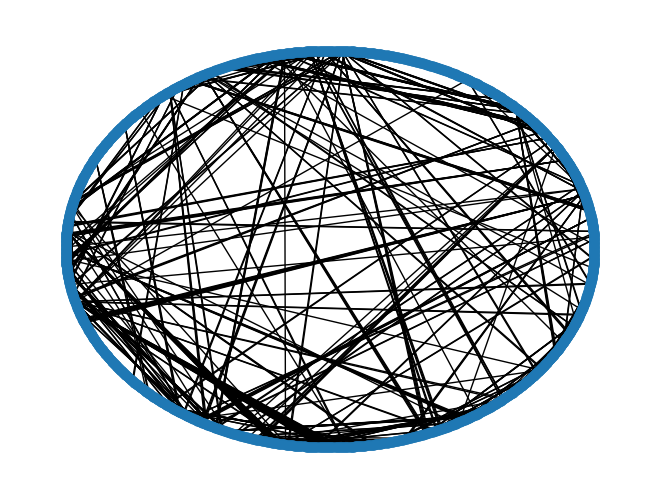

In [10]:
# Visualize the graph layout (optional)
pos = nx.drawing.circular_layout(G)
nx.draw(G, pos=pos, node_size=40)